# Fake News Detection with Naive Bayes
---
This notebook demonstrates how to build a **Naive Bayes classifier** to detect fake vs. real news using a dataset of news articles.
We will cover:
1. Exploratory Data Analysis (EDA)
2. Text Preprocessing & Feature Engineering
3. Model Training (Naive Bayes)
4. Evaluation (Accuracy, Precision, Recall, F1)
5. Visualization (Confusion Matrix, Top Words)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
import numpy as np

## 1. Load Dataset

In [5]:
df = pd.read_csv('/content/Assignment_Data_fake_or_real_news.csv')
df.head()

,id,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## 2. Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


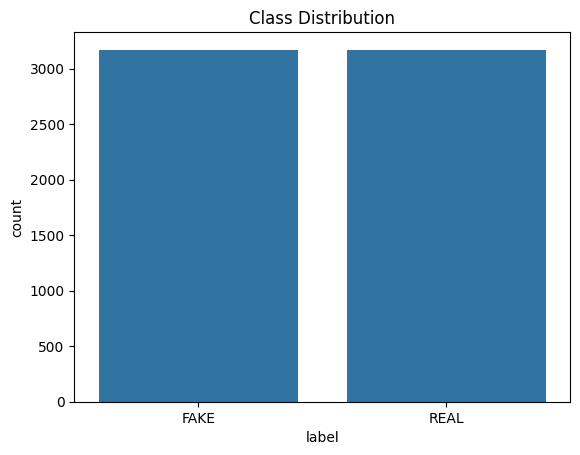

In [6]:
print(df.info())
print(df['label'].value_counts())
sns.countplot(data=df, x='label')
plt.title('Class Distribution')
plt.show()

## 3. Data Preparation (Title + Text)

In [7]:
df['content'] = df['title'] + ' ' + df['text']
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'],
                                                    test_size=0.2, random_state=42, stratify=df['label'])

## 4. Naive Bayes Model

In [8]:
model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.7)),
    ('nb', MultinomialNB())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## 5. Evaluation

Accuracy: 0.846093133385951
              precision    recall  f1-score   support

        FAKE       0.98      0.71      0.82       633
        REAL       0.77      0.99      0.87       634

    accuracy                           0.85      1267
   macro avg       0.88      0.85      0.84      1267
weighted avg       0.88      0.85      0.84      1267



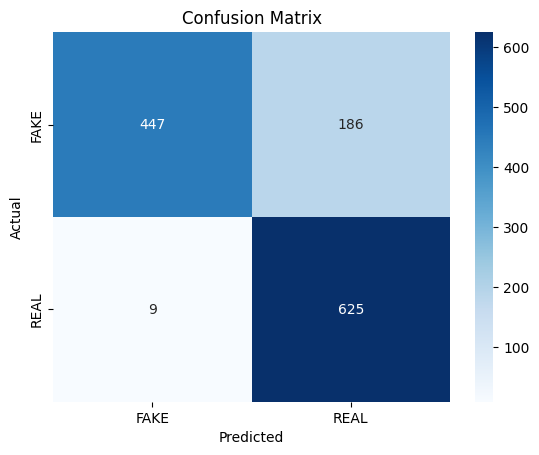

In [9]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print(metrics.classification_report(y_test, y_pred))

conf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE','REAL'], yticklabels=['FAKE','REAL'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 6. Feature Importance (Top Words per Class)

In [10]:
vectorizer = model.named_steps['tfidf']
nb = model.named_steps['nb']
feature_names = np.array(vectorizer.get_feature_names_out())
log_probs = nb.feature_log_prob_

top_fake = feature_names[np.argsort(log_probs[0])[-15:]]
top_real = feature_names[np.argsort(log_probs[1])[-15:]]

print('Top words indicating FAKE news:', top_fake)
print('Top words indicating REAL news:', top_real)

Top words indicating FAKE news: ['like' 'emails' 'just' 'new' 'war' 'world' 'said' 'russia' '2016' 'fbi'
 'people' 'election' 'hillary' 'clinton' 'trump']
Top words indicating REAL news: ['house' 'people' 'percent' 'new' 'party' 'state' 'republican' 'campaign'
 'cruz' 'president' 'sanders' 'obama' 'clinton' 'said' 'trump']


## 7. Extra EDA: Word Clouds & Text Length Distributions

In [11]:
from wordcloud import WordCloud\n\n# Word Cloud for FAKE news\nfake_text = ' '.join(df[df['label']=='FAKE']['content'])\nwc_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)\nplt.figure(figsize=(10,5))\nplt.imshow(wc_fake, interpolation='bilinear')\nplt.axis('off')\nplt.title('Word Cloud - FAKE News')\nplt.show()\n\n# Word Cloud for REAL news\nreal_text = ' '.join(df[df['label']=='REAL']['content'])\nwc_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)\nplt.figure(figsize=(10,5))\nplt.imshow(wc_real, interpolation='bilinear')\nplt.axis('off')\nplt.title('Word Cloud - REAL News')\nplt.show()

SyntaxError: unexpected character after line continuation character (ipython-input-2623651558.py, line 1)

In [12]:
# Distribution of article length (in words)\ndf['text_length'] = df['content'].apply(lambda x: len(x.split()))\nsns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)\nplt.title('Distribution of Article Length by Label')\nplt.xlabel('Number of Words')\nplt.ylabel('Count')\nplt.show()

## 8. ROC Curve & AUC Score

In [13]:
from sklearn.metrics import roc_curve, auc\nfrom sklearn.preprocessing import LabelBinarizer\n\n# Binarize labels (FAKE=0, REAL=1)\nlb = LabelBinarizer()\ny_test_bin = lb.fit_transform(y_test)\ny_pred_proba = model.predict_proba(X_test)[:,1]\n\n# ROC Curve\nfpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba)\nroc_auc = auc(fpr, tpr)\n\nplt.figure(figsize=(7,6))\nplt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)\nplt.plot([0, 1], [0, 1], color='gray', linestyle='--')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('Receiver Operating Characteristic (ROC)')\nplt.legend(loc='lower right')\nplt.show()

SyntaxError: unexpected character after line continuation character (ipython-input-2275084275.py, line 1)